<a href="https://colab.research.google.com/github/EnglishDevil/hello-world/blob/master/Artificial_Intelligence_Coursework_1_working_network_45_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Inteligence Coursework 1
## Question 1

In [ ]:
#Get the images from GIT
!git clone https://github.com/MohammedAlghamdi/imagenet10.git images
from PIL import Image 

fatal: destination path 'images' already exists and is not an empty directory.


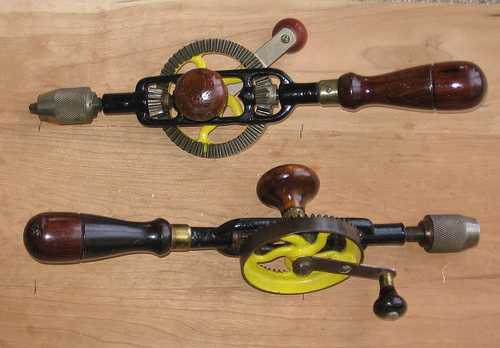

In [ ]:
Image.open("/content/images/test_set/abamijvuqu.JPEG")

In [ ]:
"""

QUESTION 1

config.py

Defines config variables 

configuration variables including directories which you can set

"""


# Define where your training and validation data is
# TODO: change this to your data root as needed
ROOT_DIR = "/content/images/train_set/"


NORM_MEAN = [0.52283615, 0.47988218, 0.40605107]
NORM_STD = [0.29770654, 0.2888402, 0.31178293]

# Define the class labels
CLASS_LABELS = (
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
)

In [ ]:
"""

QUESTION 1

PyTorch dataset class for ImageNet10.

defines class ImageNet10 which inherits from the PyTorch Dataset class

"""

from torch.utils.data import Dataset
from PIL import Image


class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

### Confident this fine. Got the train_loader, valid_loader 128*128 images

In [ ]:
"""

QUESTION 1

Some helpful code for getting started.

some code which builds the training and validation datasets and loaders using the ImageNet10 class


"""


import torch
import torchvision
import torchvision.transforms as transforms
#from imagenet10 import ImageNet10

import pandas as pd
import os

#from config import *

# Gathers the meta data for the images
paths, classes = [], []
for i, dir_ in enumerate(CLASS_LABELS):
    for entry in os.scandir(ROOT_DIR + dir_):
        if (entry.is_file()):
            paths.append(entry.path)
            classes.append(i)
            
data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

# See what the dataframe now contains
print("Found", len(data_df), "images.")
# If you want to see the image meta data
print(data_df.head())



# Split the data into train and test sets and instantiate our new ImageNet10 objects.
train_split = 0.80 # Defines the ratio of train/valid data.

# valid_size = 1.0 - train_size
train_size = int(len(data_df)*train_split)


data_transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.ColorJitter(hue=0.2, brightness=0.2,saturation=0.2),
        transforms.Normalize(NORM_MEAN, NORM_STD),
    ])


dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

dataset_valid = ImageNet10(
    df=data_df[train_size:].reset_index(drop=True),
    transform=data_transform,
)


# Data loaders for use during training
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

# See what you've loaded
print("len(dataset_train)", len(dataset_train))
print("len(dataset_valid)", len(dataset_valid))

print("len(train_loader)", len(train_loader))
print("len(valid_loader)", len(valid_loader))






Found 9000 images.
                                                path  class
0  /content/images/train_set/football/n04254680_4...      7
1  /content/images/train_set/football/n04254680_4...      7
2  /content/images/train_set/desk/n03179701_8445....      4
3  /content/images/train_set/drill/n03239726_2294...      5
4  /content/images/train_set/orange/n07747607_796...      9
len(dataset_train) 7200
len(dataset_valid) 1800
len(train_loader) 113
len(valid_loader) 15


## Set up the GPU - works fine

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev)  

device

device(type='cuda', index=0)

## imshow plus the line to change the column order - works fine

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


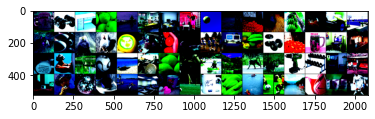

labels ['mug', 'dumbbell', 'desk', 'orange', 'canoe', 'desk', 'desk', 'dumbbell', 'football', 'cat']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images and labels
timshow(torchvision.utils.make_grid(images, nrow=16))

print(f"labels {[CLASS_LABELS[labels[i]] for i in range(10)]}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


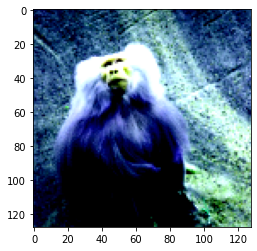

In [ ]:
timshow(torchvision.utils.make_grid(images[18]))

## **Computation** of loss and accuracy for given dataset loader and model - from labs notebook

In [ ]:
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            running_loss += loss
            n += 1
    return running_loss/n, correct/total 

## Define model

Image size is (N x N) * (F x F) = (N-F+1)x(N-F+1)

(128-7+1)

## Simple test Question 1.1

In [ ]:
# # #Simple test net
# # net = nn.Sequential(
# #     nn.Flatten(),
# #     nn.Linear(3*128*128,64),
# #     nn.ReLU(),
# #     nn.Linear(64,10)
# # )    

## More complex Question 1.2 and 2

In [ ]:
# from torch import nn, optim

# # 128*128

# # net = nn.Sequential(#input is 3*128*128
# #     nn.Conv2d(3,8, kernel_size=5, padding=0), # 0 means 1 padding?
# #     nn.ReLU(), # -2 = 8*126*126
# #     nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 63*63
# #     nn.Conv2d(8,16, kernel_size=5, padding=0),
# #     nn.ReLU(), # -2 = 61*61
# #     nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 30*30
# #     nn.Flatten(),
# #     nn.Linear(16*30*30,64), #this I need to work out at the right dimension. the 5*5 is wrong
# #     nn.ReLU(),
# #     nn.Linear(64,10)
# # )

# #40+% network network
# net = nn.Sequential(#input is 3*128*128
#     nn.Conv2d(3,20, kernel_size=7, stride=2, padding=0),
#     nn.ReLU(), # (128-7+1)/2 = 61
#     nn.Conv2d(20,20, kernel_size=3, padding=0),
#     nn.ReLU(), # 122-3+1 = 59

#     nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 29
#     nn.Dropout(p=0.25),

#     nn.Conv2d(20,40, kernel_size=3, padding=0),
#     nn.ReLU(), # 29-3+1 = 27
#     nn.Conv2d(40,40, kernel_size=3, padding=0),
#     nn.ReLU(), # 27-3+1 = 25

#     nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 12
    
#     nn.Dropout(p=0.25),

#     nn.Conv2d(40,80, kernel_size=3, padding=0),
#     nn.ReLU(), #12-3+1 = 10
#     nn.Conv2d(80,80, kernel_size=3, padding=0),
#     nn.ReLU(), #10-3+1 = 8

#     # # nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 12
#     # # nn.Dropout(p=0.25),

#     nn.Flatten(),
#     nn.Dropout(p=0.25),
#     nn.Linear(80*8*8
#               ,128),
#     nn.ReLU(),
#     nn.Linear(128,128),
#     nn.ReLU(),
#     nn.Linear(128,10)
# )

# # # overfit network
# # net = nn.Sequential(#input is 3*128*128
# #     nn.Conv2d(3,8, kernel_size=5, padding=2),
# #     nn.ReLU(), # -2 +2 padding = 8*128*126

# #     nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 64*64

# #     nn.Flatten(),
# #     nn.Linear(8*64*64,64),
# #     nn.ReLU(),
# #     nn.Linear(64,10)
# # )



torch.Size([20, 3, 7, 7])
torch.Size([20])
torch.Size([20, 20, 3, 3])
torch.Size([20])
torch.Size([40, 20, 3, 3])
torch.Size([40])
torch.Size([40, 40, 3, 3])
torch.Size([40])
torch.Size([80, 40, 3, 3])
torch.Size([80])
torch.Size([80, 80, 3, 3])
torch.Size([80])
torch.Size([128, 5120])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


## Older network that still seems to preform quite well

In [ ]:
#copied network from earlier notebook - 49 - 50%)
net = nn.Sequential(#input is 3*128*128
 nn.Conv2d(3,8, kernel_size=5, padding=2),
 nn.ReLU(), # -2 +2 padding = 8*128*126
 nn.Conv2d(8,8, kernel_size=5, padding=2),
 nn.ReLU(), # -2 + padding = 64*64
 
 nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 64*64
 nn.Conv2d(8,16, kernel_size=5, padding=2),
 nn.ReLU(), # -2 + padding = 64*64
 nn.Conv2d(16,16, kernel_size=5, padding=2),
 nn.ReLU(), # -2 + padding = 64*64

 nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 32*32

 nn.Conv2d(16,32, kernel_size=5, padding=2),
 nn.ReLU(), # -2 + padding = 32*32

 nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 16*16

 nn.Conv2d(32,64, kernel_size=5, padding=2),
 nn.ReLU(), # -2 + padding = 16*16
 nn.Conv2d(64,64, kernel_size=5, padding=2),
 nn.ReLU(), # -2 + padding = 16*16

 nn.MaxPool2d(kernel_size=2, stride=2), # divide by 2 = 8*8

 nn.Flatten(),
 nn.Linear(64*8*8,128),
 nn.ReLU(),
 nn.Linear(128,10)
)


In [ ]:
net = net.to(device)

for param in net.parameters():
    print(param.shape)

# Train model

## Question 1.1 Single Batch overfitting

In [ ]:
# # Siungle batch one for Question 1.1

# nepochs = 30
# statsrec = np.zeros((3,nepochs))

# loss_fn = nn.CrossEntropyLoss()
# #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# single_batch = iter(train_loader).next()


# for epoch in range(nepochs):  # loop over the dataset multiple times

#     running_loss = 0.0
#     n = 0
    
#     #the dataset is simply one batch of the train_loader
#     inputs, labels = single_batch
#     inputs = inputs.to(device)
#     labels = labels.to(device)
        
#     # Zero the parameter gradients
#     optimizer.zero_grad()

#     # Forward, backward, and update parameters
#     outputs = net(inputs)
#     loss = loss_fn(outputs, labels)
#     loss.backward()
#     optimizer.step()
    
#     # accumulate loss
#     running_loss += loss.item()
#     n += 1
    
#     ltrn = running_loss/n
#     ltst, atst = stats(valid_loader, net)
#     statsrec[:,epoch] = (ltrn, ltst, atst)
#     print(f"epoch: {epoch} training loss: {ltrn: .3f}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

## Question 1.2 Make a better network

In [ ]:
nepochs = 10
statsrec = np.zeros((3,nepochs))

loss_fn = nn.CrossEntropyLoss() #this includes the softmax if i remember?
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(nepochs):  # loop over the dataset multiple times

    running_loss = 0.0
    n = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
    
    ltrn = running_loss/n
    ltst, atst = stats(valid_loader, net)
    statsrec[:,epoch] = (ltrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

epoch: 0 training loss:  2.101  test loss:  2.002 test accuracy:  25.3%
epoch: 1 training loss:  1.968  test loss:  1.854 test accuracy:  29.5%
epoch: 2 training loss:  1.898  test loss:  1.876 test accuracy:  33.2%
epoch: 3 training loss:  1.801  test loss:  1.759 test accuracy:  35.9%
epoch: 4 training loss:  1.708  test loss:  1.726 test accuracy:  37.6%
epoch: 5 training loss:  1.664  test loss:  1.738 test accuracy:  38.9%
epoch: 6 training loss:  1.620  test loss:  1.710 test accuracy:  40.8%
epoch: 7 training loss:  1.569  test loss:  1.675 test accuracy:  40.1%
epoch: 8 training loss:  1.499  test loss:  1.652 test accuracy:  40.1%
epoch: 9 training loss:  1.465  test loss:  1.590 test accuracy:  45.6%
epoch: 10 training loss:  1.407  test loss:  1.617 test accuracy:  43.1%
epoch: 11 training loss:  1.325  test loss:  1.608 test accuracy:  45.2%
epoch: 12 training loss:  1.305  test loss:  1.600 test accuracy:  45.9%
epoch: 13 training loss:  1.229  test loss:  1.617 test accur

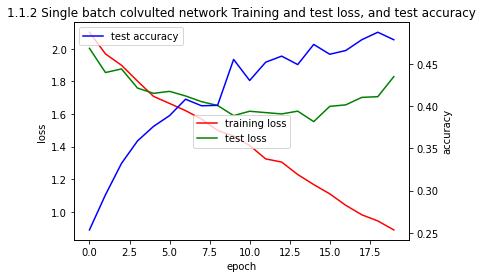

In [ ]:
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[1], 'g', label = 'test loss' )
plt.legend(loc='center')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('1.1.2 Single batch colvulted network Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[2], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper left')
plt.show()